In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import sys
sys.path.append("/content/drive/MyDrive/lab/2021/MyTabCNN/model")
from MyDataGenerator import MyDataGenerator

In [22]:
# coding:utf-8

import pandas as pd
import sys
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
# from pydub import AudioSegment
# from pydub.playback import play
import IPython.display
from scipy.io import wavfile
import librosa
from librosa import display
import os
from MyDataGenerator import MyDataGenerator
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.onnx as onnx
import torchvision.models as models
import datetime

batch_size=128 
epoch=8
con_win_size = 9
spec_repr="c"
data_path="/content/drive/MyDrive/lab/2021/MyTabCNN/data/spec_repr/"
id_file="id.csv"
save_path="saved/"
    
save_folder = save_path + spec_repr + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
log_file = save_folder + "log.txt"

metrics = {}
metrics["pp"] = []
metrics["pr"] = []
metrics["pf"] = []
metrics["tp"] = []
metrics["tr"] = []
metrics["tf"] = []
metrics["tdr"] = []
metrics["data"] = ["g0","g1","g2","g3","g4","g5","mean","std dev"]

if spec_repr == "c":
    input_shape = (192, con_win_size, 1)
elif spec_repr == "m":
    input_shape = (128, con_win_size, 1)
elif spec_repr == "cm":
    input_shape = (320, con_win_size, 1)
elif spec_repr == "s":
    input_shape = (1025, con_win_size, 1)
    
# these probably won't ever change
num_classes = 21
num_strings = 6

csv_file = data_path + id_file
list_IDs = list(pd.read_csv(csv_file, header=None)[0])

def partition_data(data_split):
    data_split = data_split
    partition = {}
    partition["training"] = []
    partition["validation"] = []
    for ID in list_IDs:
        guitarist = int(ID.split("_")[0])
        if guitarist == data_split:
            partition["validation"].append(ID)
        else:
            partition["training"].append(ID)

    training_generator = MyDataGenerator(partition['training'], 
                                            data_path=data_path, 
                                            batch_size=batch_size, 
                                            shuffle=True,
                                            spec_repr=spec_repr, 
                                            con_win_size=con_win_size)
    
    validation_generator = MyDataGenerator(partition['validation'], 
                                            data_path=data_path, 
                                            batch_size=batch_size, 
                                            shuffle=False,
                                            spec_repr=spec_repr, 
                                            con_win_size=con_win_size)
    split_folder = save_folder + str(data_split) + "/"
    if not os.path.exists(split_folder):
            os.makedirs(split_folder)
    return training_generator, validation_generator

class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 64, 3)
 
        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライド

        self.drop1 = torch.nn.Dropout2d(0.25)
        self.drop2 = torch.nn.Dropout(0.5)
        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(5952,128)
        self.fc2 = torch.nn.Linear(128,126)
        
 
    def forward(self, x):
        # print(x.size())
        x = f.relu(self.conv1(x))
        # print(x.size())
        x = f.relu(self.conv2(x))
        #print(x.size())
        x = f.relu(self.conv3(x))
        #print(x.size())
        x = self.pool(x)
        #print(x.size())
        x = self.drop1(x)
        #print(x.size())
        x = self.flatten(x)
        #print(x.size())
        x = f.relu(self.fc1(x))
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        x = torch.reshape(x, (128, 6, 21)) 
        #m = nn.Softmax(dim=2)
        x_out = x
        #print(x_out.shape)
        return x_out

class MyVGG(torch.nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = torch.nn.Conv2d(32, 32, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = torch.nn.Conv2d(64, 64, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = torch.nn.Conv2d(64, 128, 3, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = torch.nn.Conv2d(128, 256, 3, padding=1)
    self.bn6 = nn.BatchNorm2d(256)
    self.conv7 = torch.nn.Conv2d(256, 256, 3, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = torch.nn.Conv2d(256, 512, 3, padding=1)
    self.bn8 = nn.BatchNorm2d(512)
    self.conv9 = torch.nn.Conv2d(512, 512, 3, padding=1)
    self.bn9 = nn.BatchNorm2d(512)
    self.relu = nn.ReLU(inplace=True)

    self.pool = torch.nn.MaxPool2d(2, 2)

    self.drop1 = torch.nn.Dropout2d(0.25)
    self.drop2 = torch.nn.Dropout(0.5)
    self.flatten = torch.nn.Flatten()

    self.fc1 = torch.nn.Linear(196608,64)
    self.fc2 = torch.nn.Linear(64,126)

  def forward(self, x):
    #print(x.size())
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv3(out)
    out = self.bn3(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv4(out)
    out = self.bn4(out)
    out = self.relu(out)
    #print(out.size())
    out = self.conv5(out)
    out = self.bn5(out)
    out = self.relu(out)
    out = self.conv6(out)
    out = self.bn6(out)
    out = self.relu(out)
    out = self.conv7(out)
    out = self.bn7(out)
    out = self.relu(out)
    out = self.conv8(out)
    out = self.bn8(out)
    out = self.relu(out)
    out = self.conv9(out)
    out = self.bn9(out)
    out = self.relu(out)

    out = self.pool(out)
    out = self.drop1(out)
    #print(out.size())
    out = self.flatten(out)
    #print(out.size())
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = torch.reshape(out, (64, 6, 21)) 

    return out

tabcnnpath = "/content/drive/MyDrive/lab/2021/MyTabCNN/model/mytabcnn-model.path"
vggpath = "/content/drive/MyDrive/lab/2021/MyTabCNN/model/myvgg-model.path"

In [23]:
training_generator, validation_generator = partition_data(0)
print(len(training_generator))
training_generator[3300]

393800


(array([[[[6.91952145e-310],
          [6.91952145e-310],
          [6.91952145e-310],
          ...,
          [6.91952145e-310],
          [6.91952145e-310],
          [6.91952145e-310]],
 
         [[6.91952145e-310],
          [6.91952145e-310],
          [6.91952145e-310],
          ...,
          [6.91952145e-310],
          [6.91952145e-310],
          [6.91952145e-310]],
 
         [[6.91952145e-310],
          [6.91952145e-310],
          [6.91952145e-310],
          ...,
          [6.91952145e-310],
          [6.91952145e-310],
          [6.91952145e-310]],
 
         ...,
 
         [[6.91952158e-310],
          [6.91952158e-310],
          [6.91952158e-310],
          ...,
          [6.91952158e-310],
          [6.91952158e-310],
          [6.91952158e-310]],
 
         [[6.91952158e-310],
          [6.91952158e-310],
          [6.91952158e-310],
          ...,
          [6.91952158e-310],
          [6.91952158e-310],
          [6.91952158e-310]],
 
         [[6.91952158e-3

In [24]:
import numpy as np
import matplotlib.pyplot as plt
#tabcnn = np.load('saved2/c_2022-04-28_22-45-47/tabcnn-history.npy', allow_pickle=True)
#vgg = np.load('saved2/c_2022-04-28_22-46-11/vgg-history.npy', allow_pickle=True)

In [ ]:
tabcnn = tabcnn.item()
vgg = vgg.item()

NameError: ignored

In [ ]:
print(len(tabcnn))
vgg["train_loss"]

3


[2.542421579360962,
 2.2413628101348877,
 1.8811485767364502,
 2.2084333896636963,
 1.7005335092544556,
 1.2649277448654175,
 1.271543025970459,
 1.167762279510498]

In [ ]:
tabcnn_loss = []
for i in tabcnn["train_loss"]:
    tabcnn_loss.append(i)
vgg_loss = []
for i in vgg["train_loss"]:
    vgg_loss.append(i)
tabcnn_trainacc = []
for i in tabcnn["train_acc"][0].keys():
    n = []
    for j in tabcnn["train_acc"]:
        n.append(j[i])
    tabcnn_trainacc.append(n)
vgg_trainacc =[]
for i in vgg["train_acc"][0].keys():
    #print(i)
    n = []
    for j in vgg["train_acc"]:
        n.append(j[i])
    vgg_trainacc.append(n)
tabcnn_testacc = []
for i in tabcnn["test_acc"][0].keys():
    n = []
    for j in tabcnn["test_acc"]:
        n.append(j[i])
    tabcnn_testacc.append(n)
vgg_testacc =[]
for i in vgg["test_acc"][0].keys():
    #print(i)
    n = []
    for j in vgg["test_acc"]:
        n.append(j[i])
    vgg_testacc.append(n)

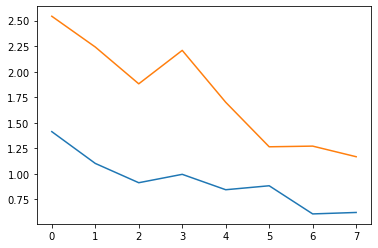

In [ ]:
plt.plot(tabcnn_loss)
plt.plot(vgg_loss)
plt.show()

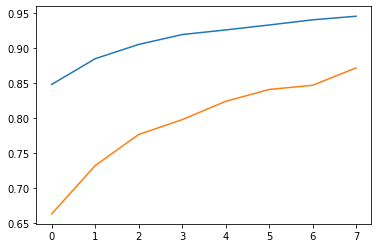

In [ ]:
plt.plot(tabcnn_trainacc[5])
plt.plot(vgg_trainacc[5])
plt.show()

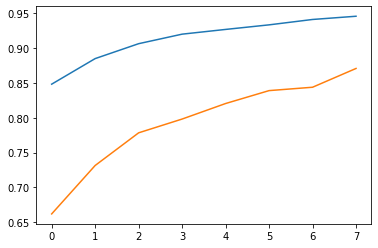

In [ ]:
plt.plot(tabcnn_testacc[5])
plt.plot(vgg_testacc[5])
plt.show()

In [ ]:
!pip install pydub

In [25]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import IPython.display

In [40]:
audio_path = "../data/GuitarSet/audio/audio_mic/00_Jazz3-137-Eb_solo_mic.wav"
fig = plt.figure()

ims = []
for h in range(9):
  data = validation_generator[h][1]
  for i in data:
    im = Image.new('RGB', (500, 350), (255, 255, 255))
    draw = ImageDraw.Draw(im)

    for j in range(6):
      draw.line(((23, (j+1) * 50), (480, (j+1) * 50)), fill=(0, 0, 0), width=2)
    for j in range(20):
      draw.line((((j+1) * 23, 50), ((j+1) * 23, 300)), fill=(0, 0, 0), width=2)

    for string, j in enumerate(i):
      for fret, k in enumerate(j):
        if not fret == 0:
            if k == 1:
              draw.pieslice(((-17 + fret*23, 45 + (5-string)*50), (-7 + fret*23, 55 + (5-string)*50)), start=0, end=360, fill=(255, 0, 0))
    im = plt.imshow(np.array(im))
    
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=25)
rc('animation', html='jshtml')
plt.close()

In [41]:
ani

Output hidden; open in https://colab.research.google.com to view.

In [39]:
net = MyCNN()
net = torch.load(tabcnnpath,map_location='cuda:0')

(128, 6, 21)


KeyboardInterrupt: ignored

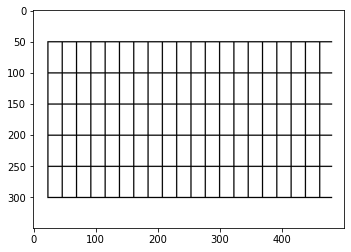

In [43]:
training_generator, validation_generator = partition_data(0)
fig = plt.figure()
ims2 = []
for h in range(9):
  input_data = validation_generator[h]
  images = input_data[0].astype(np.float32)
  images = torch.tensor(np.transpose(images, (0,3,1,2)), device = "cuda")
  outputs = net(images)
  _, predicted = torch.max(outputs.data, 2)
  data = np.zeros(((128, 6, 21)))
  for i, strings in enumerate(predicted):
    for j, fret in enumerate(strings):
      data[i][j][fret] = 1
  print(data.shape)

  for i in data:
    im = Image.new('RGB', (500, 350), (255, 255, 255))
    draw = ImageDraw.Draw(im)

    for j in range(6):
      draw.line(((23, (j+1) * 50), (480, (j+1) * 50)), fill=(0, 0, 0), width=2)
    for j in range(20):
      draw.line((((j+1) * 23, 50), ((j+1) * 23, 300)), fill=(0, 0, 0), width=2)

    for string, j in enumerate(i):
      for fret, k in enumerate(j):
        if not fret == 0:
            if k == 1:
              draw.pieslice(((-17 + fret*23, 45 + (5-string)*50), (-7 + fret*23, 55 + (5-string)*50)), start=0, end=360, fill=(255, 0, 0))
    im = plt.imshow(np.array(im))
    
    ims2.append([im])

ani = animation.ArtistAnimation(fig, ims2, interval=25)
rc('animation', html='jshtml')
plt.close()
ani

In [44]:
net = MyVGG()
net = torch.load(vggpath,map_location='cuda:0')

In [ ]:
!nvidia-smi

Tue May  3 08:21:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |  15098MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
training_generator, validation_generator = partition_data(0)
fig = plt.figure()
ims2 = []
for h in range(9):
  input_data = validation_generator[h]
  images = input_data[0].astype(np.float32)
  image1 = images[:64]
  image2 = images[64:]
  image1 = torch.tensor(np.transpose(image1, (0,3,1,2)), device = "cuda")
  image2 = torch.tensor(np.transpose(image2, (0,3,1,2)), device = "cuda")
  print(image1.size())
  output = net(image1)
  _, predicted = torch.max(output.data, 2)
  data1 = np.zeros(((64, 6, 21)), dtype=int)
  for i, strings in enumerate(predicted):
    for j, fret in enumerate(strings):
      data1[i][j][fret] = 1
  output = net(image2)
  _, predicted = torch.max(output.data, 2)
  data2 = np.zeros(((64, 6, 21)), dtype=int)
  for i, strings in enumerate(predicted):
    for j, fret in enumerate(strings):
      data2[i][j][fret] = 1
  print(data1.shape, data2.shape)
  data = np.concatenate([data1,data2])
  print(data.shape)

  for i in data:
    im = Image.new('RGB', (500, 350), (255, 255, 255))
    draw = ImageDraw.Draw(im)

    for j in range(6):
      draw.line(((23, (j+1) * 50), (480, (j+1) * 50)), fill=(0, 0, 0), width=2)
    for j in range(20):
      draw.line((((j+1) * 23, 50), ((j+1) * 23, 300)), fill=(0, 0, 0), width=2)

    for string, j in enumerate(i):
      for fret, k in enumerate(j):
        if not fret == 0:
            if k == 1:
              draw.pieslice(((-17 + fret*23, 45 + (5-string)*50), (-7 + fret*23, 55 + (5-string)*50)), start=0, end=360, fill=(255, 0, 0))
    im = plt.imshow(np.array(im))
    
    ims2.append([im])

ani = animation.ArtistAnimation(fig, ims2, interval=25)
rc('animation', html='jshtml')
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
class AudioDataGenerator:
  def __init__(self, path, mode="c"):
    self.path = path

    # prepresentation and its labels storage
    self.output = {}

    self.preproc_mode = mode
    self.downsample = True
    self.normalize = True
    self.sr_downs = 22050

    # CQT parameters
    self.cqt_n_bins = 192
    self.cqt_bins_per_octave = 24

    # STFT parameters
    self.n_fft = 2048
    self.hop_length = 512

  def load_audiodata(self):
    file_path = self.path
    file_audio = file_path
    self.sr_original, data = wavfile.read(file_audio)
    self.sr_curr = self.sr_original

    # preprocess audio, store in output dict
    self.output["repr"] = np.swapaxes(self.preprocess_audio(data),0,1)

    # construct labels
    frame_indices = range(len(self.output["repr"]))
    times = librosa.frames_to_time(frame_indices, sr = self.sr_curr, hop_length=self.hop_length)

    labels = np.zeros(((128, 6 ,21)))
    # store and return
    self.output["labels"] = labels
    print(np.shape(self.output["repr"]))
    print(np.shape(self.output["labels"]))
    return self.output

  def preprocess_audio(self, data):
      data = data.astype(float)
      if self.normalize:
          data = librosa.util.normalize(data)
      if self.downsample:
          data = librosa.resample(data, self.sr_original, self.sr_downs)
          self.sr_curr = self.sr_downs
      if self.preproc_mode == "c":
          data = np.abs(librosa.cqt(data,
              hop_length=self.hop_length, 
              sr=self.sr_curr, 
              n_bins=self.cqt_n_bins, 
              bins_per_octave=self.cqt_bins_per_octave))
          cqt_amplitude = data
          fig = plt.figure()
          ax = fig.add_subplot()
          librosa.display.specshow(librosa.amplitude_to_db(cqt_amplitude, ref=np.max), sr=self.sr_curr, x_axis='time', y_axis='cqt_hz')
          plt.colorbar(format='%+2.0f dB')
          ax.set_title('constant-Q power spectrum')
          plt.tight_layout()
          plt.show()
    
      elif self.preproc_mode == "m":
          data = librosa.feature.melspectrogram(y=data, sr=self.sr_curr, n_fft=self.n_fft, hop_length=self.hop_length)
      elif self.preproc_mode == "cm":
          cqt = np.abs(librosa.cqt(data, 
              hop_length=self.hop_length, 
              sr=self.sr_curr, 
              n_bins=self.cqt_n_bins, 
              bins_per_octave=self.cqt_bins_per_octave))
          mel = librosa.feature.melspectrogram(y=data, sr=self.sr_curr, n_fft=self.n_fft, hop_length=self.hop_length)
          data = np.concatenate((cqt,mel),axis = 0)
      elif self.preproc_mode == "s":
          data = np.abs(librosa.stft(data, n_fft=self.n_fft, hop_length=self.hop_length))
      else:
          print ("invalid representation mode.")
      print(np.shape(data))

      return data

In [ ]:
class DataGenerator2():
    
    def __init__(self, data, batch_size=128, shuffle=False, label_dim = (6,21), spec_repr="c", con_win_size=9):
        
        self.list_IDs = np.arange(len(data["repr"]))
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_dim = label_dim
        self.spec_repr = spec_repr
        self.con_win_size = con_win_size
        self.halfwin = con_win_size // 2
        
        if self.spec_repr == "c":
            self.X_dim = (self.batch_size, 192, self.con_win_size, 1)
        elif self.spec_repr == "m":
            self.X_dim = (self.batch_size, 128, self.con_win_size, 1)
        elif self.spec_repr == "cm":
            self.X_dim = (self.batch_size, 320, self.con_win_size, 1)
        elif self.spec_repr == "s":
            self.X_dim = (self.batch_size, 1025, self.con_win_size, 1)
            
        self.y_dim = (self.batch_size, self.label_dim[0], self.label_dim[1])
        
        self.on_epoch_end()
        
    def __len__(self):
        # number of batches per epoch
        return int(np.floor(float(len(self.data["repr"])) / self.batch_size))
    
    def __getitem__(self, index):
        # generate indices of the batch(バッチごとのインデクス)
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        
        # find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y
    
    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.data["repr"]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        #Generates data containing batch_size samples
        # X : (n_samples, *dim, n_channels)
        
        # Initialization
        X = np.empty(self.X_dim)
        y = np.empty(self.y_dim)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # determine filename
            frame_idx = ID
            #print(i, ID)
            
            # load a context window centered around the frame index
            loaded = self.data
            full_x = np.pad(loaded["repr"], [(self.halfwin,self.halfwin), (0,0)], mode='constant')
            sample_x = full_x[frame_idx : frame_idx + self.con_win_size]
            X[i,] = np.expand_dims(np.swapaxes(sample_x, 0, 1), -1)

            # Store label
            y[i,] = loaded["labels"][0]

        return X, y